## Classification

Here we'll utilize the previous' notebook output and logic to be able to try and classify our data.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_data_dir = './data'

Reading the data that was saved to disk from the augmentation notebook.

In [3]:
latest_data_dir_num = max([int(dir.split('_')[-1]) for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit()])
data_dir = [dir for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit() and int(dir.split('_')[-1]) == latest_data_dir_num][0]
data_dir = f'{base_data_dir}/{data_dir}'

In [4]:
data_dir

'./data/decoded_data_57'

In [5]:
import h5py

In [6]:
with h5py.File(f'{data_dir}/final_images.h5') as f:
    images = f['final_images'][:].squeeze()

with h5py.File(f'{data_dir}/final_labels.h5') as f:
    labels = f['final_labels'][:]

In [7]:
images.shape

(30726, 176, 144)

In [8]:
def normalize_images(imgs, lib=np):
    imgs += lib.abs(imgs.min())
    imgs /= imgs.max()
    imgs *= 255
    return imgs

Since our first $10242$ images are normalized and properly visualized, we want to normalize the generated images.

In [9]:
# original shape of images from augmentation notebook is 10242
original_images_factor = images.shape[0] // 10242
generated_images_start_idx = images.shape[0] // original_images_factor

In [10]:
# images = images.astype(np.float32)
images[generated_images_start_idx:] = normalize_images(images[generated_images_start_idx:])
images = images.astype(np.uint8)

In [11]:
images[generated_images_start_idx:].min(), images[generated_images_start_idx:].max()

(0, 255)

In [12]:
images.shape

(30726, 176, 144)

And since those generated images are a bit blurry and noisy, I wanted to clean it as much as I could to "remove" the blurriness and make it look like a low-resolution brain image, to still be able to see the main characteristics and attributes of the brain. 

For this case, I've decided to use the SVD (Singular Value Decomposition) algorithm, which is decomposing the flattened images matrix (flattening the `xy` axes to a single `y` axis), let's call it $A$, to get the $U$, $S$ and $V^*$ matrices, where $U$ and $V^*$ are unitary matrices and $V^*$ is the conjugate transpose of $V$ such that $A = U \cdot S \cdot V^*$.

$S$ is a diagonal (`numpy` returns a vector) matrix with the singular values of $A$ in a descending order.

$U$'s and $V^*$'s columns are orthonormal bases due to them being unitary matrices. 

$U \in \mathbb{R}^{mxm}$ where $m = images.shape[0]$, i.e: $m$ = number of images,

$V \in \mathbb{R}^{nxn}$ where $n = images.shape[1]*image.shape[2] = 176*144 = 25344$ 

and $S \in \mathbb{R}^{mxn}$. 

Generally, they're all supposed to uphold $\in \mathbb{C}^{k_1 x k_2}$, with the relevant $k1$ and $k2$ values, but since $A$ is real, they are as well.

So this algorithm can help us use the $S$ diagonal matrix to use the bigger singular values of $A$ that represent "feature importance" in $A$ to filter out "non important" features and in that, clean some noise.

It is important to say the the SVD is not unique, except for the singular values, i.e: $S$ is unique but $U$, $V^*$ aren't.

NOTE: it takes a long time to compute so we've cached it for using the same data across different runs of the notebook (using the same data from the augmentation notebook).

In [13]:
if not os.path.exists(f'{data_dir}/svd.h5'):
    print('Calculating singular values and singular vectors of the flattened images matrix...')
    # 40 mins to calculate on i9 13th generation
    U, S, V_t = np.linalg.svd(images.reshape(images.shape[0], -1), full_matrices=False)

    print('Saving U, S, V_t to disk...')
    with h5py.File(f'{data_dir}/svd.h5', 'w') as f:
        f.create_dataset('U', data=U)
        f.create_dataset('S', data=S)
        f.create_dataset('V_t', data=V_t)
else:
    with h5py.File(f'{data_dir}/svd.h5') as f:
        U = f['U'][:]
        S = f['S'][:]
        V_t = f['V_t'][:]

In [14]:
U.shape, S.shape, V_t.shape

((30726, 25344), (25344,), (25344, 25344))

We'll have $S.shape[0] = 176*144 = 25344$) singular values and we care only for a certain percent of them, where the remaining singular values (and vectors) will be zeroed out to perform some sort of noise cleaning

In [15]:
k = int(0.05 * S.shape[0])
k

1267

Here we're actually performing the noise cleaning. Since $A = U \cdot diag(S) \cdot V^*$, we'll always get a matrix $A' \in \mathbb{R}^{mxn}$.

And for that, we can control which "part" of the matrices will be multiplied since we don't want to fully recover our $A$ matrix.

This is why we've calculated $k$ to use only $5 \%$ of the singular values to perform a massive cleaning.

In [16]:
# svd_images = torch.bmm(U[..., :k], torch.bmm(torch.diag_embed(S[:, :k]), V_t[:, :k, :]))
svd_images = U[..., :k] @ (np.diag(S[..., :k]) @ V_t[..., :k, :])
svd_images = svd_images.reshape(*images.shape)

In [17]:
svd_images.shape

(30726, 176, 144)

Now for the normalization to the $[0, 255]$ range of the restored images from the `SVD` process.

In [18]:
svd_images[generated_images_start_idx:].min(), svd_images[generated_images_start_idx:].max()

(-25.542690222071425, 249.51431860050954)

In [19]:
svd_images[generated_images_start_idx:] = normalize_images(svd_images[generated_images_start_idx:], lib=np)
svd_images = svd_images.astype(np.uint8)

In [20]:
svd_images.min(), svd_images.max()

(0, 255)

Text(0.5, 1.0, 'Generated Image After SVD')

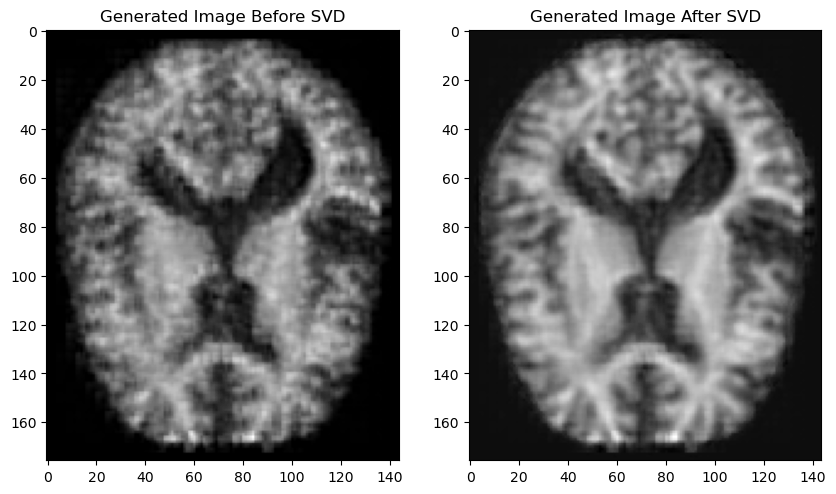

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(images[-1], cmap='gray')
axes[0].set_title('Generated Image Before SVD')
axes[1].imshow(svd_images[-1], cmap='gray')
axes[1].set_title('Generated Image After SVD')

As we can see, a large amount of noise was cleaned, the blurriness level dropped while keeping the relevant data of the image. Also, we did get a "low-resolution" image as we initially wanted.

In [22]:
images[generated_images_start_idx:].max(), images[generated_images_start_idx:].min()

(255, 0)

In [23]:
# replacing the existing blurry images with the svd ones
images[generated_images_start_idx:] = svd_images[generated_images_start_idx:]

In [24]:
data_dir='./data/alzheimer/train'
classes = os.listdir(data_dir)

In [25]:
import seaborn as sns

In [26]:
def transform_image(image, threshold=None, return_inverse=False):
    fft_image = np.fft.fft2(image)
    if threshold is None:
        threshold = 0.0000005 * np.abs(fft_image)
    # creating a mask for zeroing low amplitudes, i.e: below the threshold
    mask = np.ones_like(fft_image)
    mask[np.abs(fft_image) <= threshold] = 0
    filtered_fft_image = fft_image * mask
    # getting the inverse fourier transform on the filtered image
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    transformed_image = np.real(inverse_fft_image * np.conj(inverse_fft_image))
    # normalizing to [0, 255] range
    transformed_image = transformed_image / transformed_image.max()
    transformed_image *= 255
    if return_inverse:
        return fft_image, transformed_image
    return transformed_image

def filter(inverse):
    ones = np.ones_like(inverse)
    epsilon = 0.000001
    border = 0
    center_y, center_x = ones.shape[0]//2, ones.shape[1]//2
    center = np.array([center_y, center_x])

    ones[center_y-border:center_y+border+1, center_x-border:center_x+border+1] = 0 + epsilon
    v, u = np.mgrid[:inverse.shape[0], :inverse.shape[1]]

    distances_from_center = np.sqrt(
        np.square(v - center[0]) + np.square(u - center[1])
    )
    threshold = 40
    mask = distances_from_center <= threshold

    return inverse * mask

### Fine tuning

In [27]:
import torch

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
import torch.nn as nn

Our `ConvClassifier` is using the `ConvAutoEncoder` class from the augmentation notebook, but in the `forward` method we're only using the `encoder`.

In [30]:
import modules.models
from modules.models.models import ConvClassifier
from modules.models.dataset import AlzheimerDataset

In [31]:
import modules.db
from modules.db.optuna_report import get_best_hyperparameters

Same as with the augmentation, we'll create a train and validation datasets for the training evaluation.

In [32]:
perm = torch.randperm(images.shape[0])
val_indices = perm[:int(images.shape[0] * 0.15)].numpy()
train_indices = np.setdiff1d(np.arange(images.shape[0]), val_indices)

In [33]:
# using the same training and validation datasets from the autoencoder training
train_dataset = AlzheimerDataset(images[train_indices], labels[train_indices])
val_dataset = AlzheimerDataset(images[val_indices], labels[val_indices])

This part is important. To initialize our `classifier` we need the augmentation model's exact architecture to use the encoder, and since we saved our model as a file at the end of the previous notebook, with all the relevant parameters in its name, we can parse that name later on, given we have the parameters.

So I've decided to use the best model in all of my attempts, and not the one from the last study, and for that I'm fetching its parameters from the database.

In [34]:
params = get_best_hyperparameters(from_last_study=False) # get hyperparameters from the study, if studied

train_best_params = params
train_best_params['lr'] = train_best_params['learning_rate']

In [35]:
def train_epoch(model, optimizer, loss, dataloader, val_dataset, overall_losses, val_overall_losses, accuracy, val_accuracy, epoch, scheduler=None, writer=None):
    for _, (batch_X, batch_y) in enumerate(dataloader):
        batch_X = batch_X.to(device=model.device)
        batch_y = batch_y.to(device=model.device)

        if batch_X.shape[0] == 1:
            batch_X = torch.concat((batch_X, batch_X), dim=0).to(device=model.device)
            batch_y = torch.concat((batch_y, batch_y), dim=0).to(device=model.device)
        
        optimizer.zero_grad()
        
        batch_output = model(batch_X)
        batch_loss = loss(batch_output, batch_y)
        overall_losses[epoch] += batch_loss.item()

        predictions = torch.argmax(batch_output, dim=1).to(model.device)
        accuracy[epoch] += (predictions == batch_y).sum().item()
    
        batch_loss.backward()
        optimizer.step()
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.y.shape[0]
    accuracy[epoch] /= dataloader.dataset.y.shape[0]

    if writer:
        writer.add_scalar('Overall Loss/Train', overall_losses[epoch], epoch)
        writer.add_scalar('Accuracy/Train', accuracy[epoch], epoch)
        
    # validation
    with torch.no_grad():
        model.eval()
        val_output = model(val_dataset.X.to(model.device))
        loss_value = loss(val_output, val_dataset.y.to(model.device))

        val_overall_losses[epoch] = loss_value.item() / val_dataset.y.shape[0]

        predictions = torch.argmax(val_output, dim=1).to(model.device)
        val_accuracy[epoch] = (predictions == val_dataset.y.to(model.device)).sum().item() / predictions.shape[0]

        if writer:
            writer.add_scalar('Overall Loss/Validation', val_overall_losses[epoch], epoch)
            writer.add_scalar('Accuracy/Validation', val_accuracy[epoch], epoch)

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    

In [36]:
from tqdm.notebook import tqdm

In [37]:
import modules.db
from modules.db.optuna_report import report_optuna_trial, get_last_study_id

In [38]:
# using tensorboard for the visualizations and progress of the trials
from torch.utils.tensorboard import SummaryWriter
import optuna

In [39]:
classification_studies_dir = './data/studies/classification'
if not os.path.isdir(classification_studies_dir):
    os.mkdir(classification_studies_dir)
studies_directories = os.listdir(classification_studies_dir)
# if last study wasn't finished, use that study id in tensorboard and later on in resuming the optuna study
if len(studies_directories) > 0:
    current_study_id = studies_directories[-1].split('-')[-1]
# last study finished successfully so we'll start a brand new one
else:
    current_study_id = get_last_study_id()
current_study_id

69

### Training functions

In [40]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True):
    log_dir = f'./logs/classification/study-{current_study_id}/trial-{trial.number}' if trial else f'./logs/classification/study-{current_study_id}/final'
    writer = SummaryWriter(log_dir=log_dir)

    writer.add_graph(model, next(iter(dataloader))[0].to(device=model.device))
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    accuracy, val_accuracy = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            accuracy=accuracy,
            val_accuracy=val_accuracy,
            overall_losses=overall_losses,
            scheduler=scheduler,
            writer=writer
        )

        writer.flush()
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 10))
        
        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        axes[0].legend()

        axes[1].plot(accuracy.cpu(), color='blue', label='Train Accuracy')
        axes[1].plot(val_accuracy.cpu(), color='orange', label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].legend()

    # writer.flush()
    writer.close()
    
    return (overall_losses, val_overall_losses), (accuracy, val_accuracy)

Our loss function here is different from the augmentation one, since we're using supervised learning, and we want to train a classifier, our basic options are `CrossEntropyLoss` and `NLLLoss`. 

Naturally, I've decided to let Optuna choose which one is best.

But note that we're not using the "vanilla" arguments, but we're calculating a weights vector for each of the classes and letting the loss function use those weights when calculating the loss value. This will try and balance the minority classes by giving them a larger weight when calculating the gradients, and will do the opposite for the majority classes.

In [41]:
def get_classification_loss_function(idx, weighted_loss=True, reduction='mean', device='cpu'):
    if weighted_loss:
        # getting the distribution of data
        _, counts = np.unique(labels, return_counts=True)
        counts = counts.astype(np.float32)
        for i in range(len(counts)):
            counts[i] = counts.sum() / (len(counts) * counts[i])
        # giving minority classes larger weights
        weights = torch.from_numpy(counts).to(dtype=torch.float32, device=device)
        return nn.CrossEntropyLoss(reduction=reduction, weight=weights) if idx == 0 else nn.NLLLoss(reduction=reduction, weight=weights)
    # not weighted loss
    return nn.CrossEntropyLoss(reduction=reduction) if idx == 0 else nn.NLLLoss(reduction=reduction)

NOTE: I've tweaked the values here from the augmentation notebook, again, after trial and error, and I've added a `fine_tune` parameter for deciding whether we want to actually fine tune the `encoder` or retrain its' weights.

There's an option to use different optimizer parameters for the `encoder` model, and specific ones for the `classifier`'s parameters, in the `optimizer` initialization, which will probably be best, but currently I couldn't think of the values that will be given to the `encoder` parameters.

In [42]:
def initialize_hyperparameters(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-1)
    weight_decay = trial.suggest_float('weight_decay', 0, 0.1)
    beta1 = trial.suggest_float('beta1', 0.5, 0.999)
    beta2 = trial.suggest_float('beta2', 0.5, 0.999)

    momentum = trial.suggest_float('momentum', 0, 0.75)
    dampening = trial.suggest_float('dampening', 0, 0.3)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)

    fine_tune = trial.suggest_categorical('fine_tune', [True, False])
    
    # lower the number of epochs when retraining the encoder to avoid overfitting
    if not fine_tune:
        epochs = trial.suggest_int('epochs', 4, 25)
    else:
        epochs = trial.suggest_int('epochs', 32, 72)
    
    batch_size = trial.suggest_int('batch_size', 32, 256)

    loss_function_id = trial.suggest_int('loss_function_id', 0, 1)
    reduction = trial.suggest_categorical('reduction', ['sum'])

    weighted_loss = trial.suggest_categorical('weighted_loss', [True, False])

    relu_slope = trial.suggest_float('relu_slope', 0, 0.2)
    linear_blocks = trial.suggest_categorical('linear_blocks', [True, False])

    return lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, scheduler_gamma, epochs, \
        batch_size, loss_function_id, reduction, fine_tune, weighted_loss, relu_slope, linear_blocks

In [43]:
def objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_function_id,
     reduction,
     fine_tune,
     weighted_loss,
     relu_slope,
     linear_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           relu_slope=relu_slope, device=device, fine_tune=fine_tune, linear_blocks=linear_blocks).to(device)
    # trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_function_id, weighted_loss, reduction, device=model.device)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return val_overall_losses[-1].item() # overall_train_losses[-1].item()

In [44]:
def multi_objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_function_id,
     reduction,
     fine_tune,
     weighted_loss,
     relu_slope,
     linear_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           relu_slope=relu_slope, device=device, fine_tune=fine_tune, linear_blocks=linear_blocks).to(device)
    # trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_function_id, weighted_loss, reduction, device=model.device)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None
    )
    
    overall_train_losses, val_overall_losses = overall
    # train_accuracy, val_accuracy = accuracy
    
    # TODO: check BCE vs NLLLoss scales
    return overall_train_losses[-1].item(), val_overall_losses[-1].item()

In [45]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [46]:
def optimize(is_multi_objective, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    study = optuna.create_study(directions=directions)
    study.optimize(objective_func, n_trials=n_trials, timeout=3600*(n_trials // 30), show_progress_bar=True, gc_after_trial=True) # , callbacks=[callback])
    return study

Starting the study

In [47]:
is_multi_objective = False
n_trials = 100
study = optimize(is_multi_objective=is_multi_objective, n_trials=n_trials)

[I 2025-02-01 20:43:45,565] A new study created in memory with name: no-name-8caacab3-a0a6-4aaa-a3ba-5bca2111907e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-01 20:44:32,188] Trial 0 finished with value: 0.8246742486953735 and parameters: {'lr': 0.0664261315414164, 'weight_decay': 0.09816406826996439, 'beta1': 0.9414969132407247, 'beta2': 0.8120217032217074, 'momentum': 0.24934093456825365, 'dampening': 0.1921922996463018, 'optimizer_idx': 0, 'scheduler_gamma': 0.9349492365011978, 'fine_tune': True, 'epochs': 39, 'batch_size': 148, 'loss_function_id': 0, 'reduction': 'sum', 'weighted_loss': False, 'relu_slope': 0.058261048197632365, 'linear_blocks': False}. Best is trial 0 with value: 0.8246742486953735.
[I 2025-02-01 20:45:49,567] Trial 1 finished with value: 0.539512574672699 and parameters: {'lr': 0.07361900733278608, 'weight_decay': 0.03743227986303702, 'beta1': 0.9706440227711186, 'beta2': 0.9306616539638628, 'momentum': 0.3740117854772737, 'dampening': 0.2753660138065692, 'optimizer_idx': 0, 'scheduler_gamma': 0.8238531099347833, 'fine_tune': True, 'epochs': 64, 'batch_size': 212, 'loss_function_id': 1, 'reduction': 'sum', 

In [48]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [49]:
import optuna.visualization as vis

Since the results in the below plots are non-deterministic across studies, I'll just note that for the specific study I've ran, we're seeing some unexpected parameters with the highest importances, like `beta1`.

In [50]:
vis.plot_param_importances(study)

In [51]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

Unfortunately, our study found its best parameters fairly at the beginning and didn't succeed at finding better ones.

In [52]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_optimization_history(study)
fig.show()

In [53]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [54]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_slice(study)
fig.show()

Preparing our classification model using the data from the study.

In [55]:
if is_multi_objective:
    best_trials = study.best_trials
    sorted_trials = sorted([(trial.values[1], trial.params) for trial in best_trials])
    best_params = sorted_trials[0][1]
else:
    best_params = study.best_trial.params
best_params

{'lr': 0.0015610089311819454,
 'weight_decay': 0.07500361032560723,
 'beta1': 0.6674880935024725,
 'beta2': 0.9141632628710653,
 'momentum': 0.6765592072337447,
 'dampening': 0.0813083518102023,
 'optimizer_idx': 0,
 'scheduler_gamma': 0.8878056605174024,
 'fine_tune': False,
 'epochs': 16,
 'batch_size': 256,
 'loss_function_id': 0,
 'reduction': 'sum',
 'weighted_loss': True,
 'relu_slope': 0.08030501713598283,
 'linear_blocks': False}

In [56]:
lr = best_params['lr']
weight_decay = best_params['weight_decay']
betas = (best_params['beta1'], best_params['beta2'])
momentum = best_params['momentum']
dampening = best_params['dampening']
scheduler_gamma = best_params['scheduler_gamma']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
relu_slope = best_params['relu_slope']
linear_blocks = best_params['linear_blocks']
fine_tune = best_params['fine_tune']
weighted_loss = best_params['weighted_loss']

# using the train_best_params like in the study for the encoder's architecture
model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                       relu_slope=relu_slope, device=device, fine_tune=fine_tune, linear_blocks=linear_blocks).to(device)

# trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]
if best_params['optimizer_idx'] == 0:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

loss_func = get_classification_loss_function(best_params['loss_function_id'], weighted_loss, best_params['reduction'], device=model.device)

In [57]:
best_params, sum(p.numel() for p in model.parameters())

({'lr': 0.0015610089311819454,
  'weight_decay': 0.07500361032560723,
  'beta1': 0.6674880935024725,
  'beta2': 0.9141632628710653,
  'momentum': 0.6765592072337447,
  'dampening': 0.0813083518102023,
  'optimizer_idx': 0,
  'scheduler_gamma': 0.8878056605174024,
  'fine_tune': False,
  'epochs': 16,
  'batch_size': 256,
  'loss_function_id': 0,
  'reduction': 'sum',
  'weighted_loss': True,
  'relu_slope': 0.08030501713598283,
  'linear_blocks': False},
 1635336)

In [58]:
dataset = AlzheimerDataset(images, labels)

In [59]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Training the final classifier model

  0%|          | 0/16 [00:00<?, ?it/s]

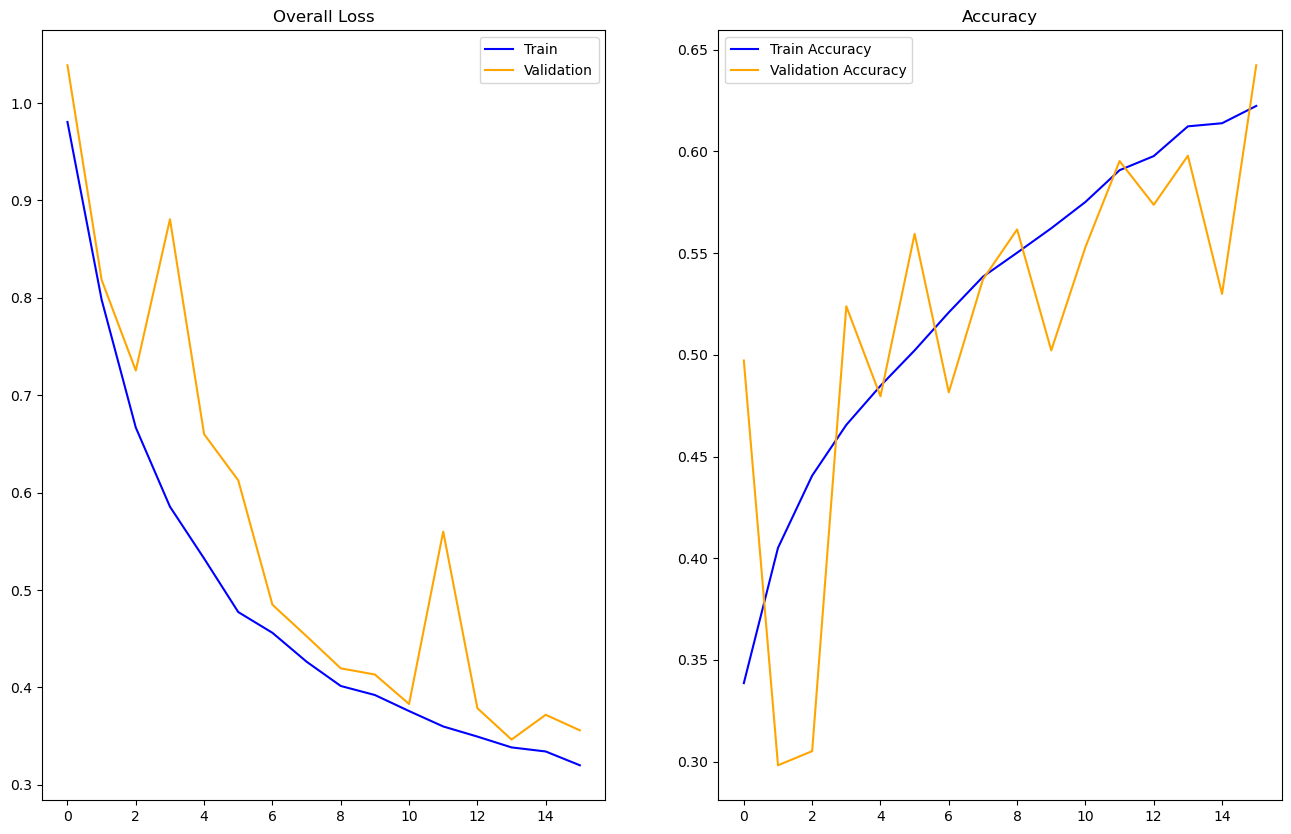

In [60]:
overall, accuracy = train(
    model=model,
    optimizer=optimizer,
    loss=loss_func,
    epochs=epochs,
    dataloader=dataloader,
    val_dataset=val_dataset,
    scheduler=scheduler,
    plot=True,
    show_progress=True,
    trial=None
)

As we can see, the validation and training loss and accuracy are fairly similar, having the same tendentiousness, which is a good sign (mostly).

If `fine_tune = False` then it's a good possibility that we've retrained our `encoder` using some of the data we've used to initially train it. Personally, I don't really like this idea, but we can look at it as we've added "more epochs" to the initial training, even though the backpropagation process is very different with our `classifier` model.

In the case where `fine_tune = True`, our training was done solely on the new layers we've added, which means the `encoder` weights and biases were left untouched, and for that the plot from above shows good promise.

### Evaluation

Now for the evaluation of the trained model.

Since we're dealing with a problem that affects a human's life, there are some metrics which we should care about more than others, and even some that we wouldn't care at all.

Let's break it down first:
* Our dataset is very imbalanced, so using `accuracy` as a performance and evaluation metric isn't the way to go, since not predicting the minority class (and somehow predicting the correct one, which is safe to assume that predicting correctly is with a probability that's higher than $\frac{1}{3}$) will cause neglecting the minority class, which we'll never get right.
* We're predicting Alzheimer's dementia levels, meaning that for a given patient that is feared to have the disease, we'd rather predict it has a stronger level of dementia than a weaker one, for which we can treat the patient more carefully, if possible, and not underestimate the severity. I'm not 100% sure of the medical consequences but logically that's a good way to think about it.
* So from the above assumptions, we'd want to measure `precision` and `recall`.

To refresh our memory, `precision` means "from all the predictions I made for class X, how many did I predict as X and was correct?", i.e: `precision = tp / (tp + fp)`.

As for `recall`, it is somewhat similar to `precision`. I like to think of it as the `precision`'s transpose. `Recall` means "from all the samples from class X, how many did I predict as X and was correct?", i.e: `recall = tp / (tp + fn)`.

My observation at it would be that using the `confusion matrix`, the `precision` is the columns and the `recall` is the rows (where the `x axis` is the predictions and the `y axis` is the true values), hence the "transpose".

Also, since we care about `precision` and `recall`, it would be natural to also measure the `F1 score`, which is, according to Wikipedia, an "harmonic mean" of those two metrics. And just to be precise, $F_1 = \frac {2TP}{2TP + FP + FN} = 2 \cdot \frac{precision \cdot recall}{precision + recall}$, so the range here is $[0, 1]$, where $1$ is best and $0$ is worst.

If we want to give "more weight" to a specific metric, we can use the $F_\beta$ score, where $\beta$ is the weight for the `recall` such that $F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}$. $\beta$ can be higher than $1$. According to Wikipedia, "Two commonly used values for $\beta$ are $2$, which weighs `recall` higher than `precision`, and $0.5$, which weighs `recall` lower than `precision`."

So in our use case here, there are classes that are more important to have a high `recall` and some to have a high `precision`. So for now, we'll give both metrics the same "weight", or say $\beta = 1$, and use the $F_1$ score.

For that, there's an option to optimize our hyperparameters search trying to optimize each of those metrics, but that would be very compute and time intensive since all trials would run. So we'll decide to keep with the decision to optimize the validation's loss.

In [61]:
model.eval()

ConvClassifier(
  (encoder): ConvEncoder(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (block0): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.2, inplace=False)
    )
    (max_pool_block0): MaxPoolBlock(
      (max_pool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=True)
      (bn): BatchNorm2d(

In [62]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [63]:
import seaborn as sns

In [64]:
def show_metrics(model, dataset, data_dir='./data/alzheimer/train'):
    classes = os.listdir(data_dir)

    output = model(dataset.X.to(model.device))
    predictions = torch.argmax(output, dim=1).to(model.device)
    accuracy = (predictions == dataset.y.to(model.device)).sum().item() / predictions.shape[0]

    print(f'Total Accuracy: {accuracy}\n')

    # choosing weighted because we want to calculate per class and then calculate the weighted sum since our labels are imbalanced
    average_policy = None

    # precision = tp / (tp + fp)
    print('Precision: ')
    precisions = precision_score(dataset.y.cpu().numpy(), predictions.cpu().numpy(), average=average_policy, zero_division=0)
    for class_idx in range(len(classes)):
        print(f'{classes[class_idx]}: {precisions[class_idx]}')
    print()

    # recall = tp / (tp + fn)
    print('Recall: ')
    recalls = recall_score(dataset.y.cpu().numpy(), predictions.cpu().numpy(), average=average_policy, zero_division=0)
    for class_idx in range(len(classes)):
        print(f'{classes[class_idx]}: {recalls[class_idx]}')
    print()

    print('F1 Score:')
    f1_scores = f1_score(dataset.y.cpu().numpy(), predictions.cpu().numpy(), average=average_policy, zero_division=0)
    for class_idx in range(len(classes)):
        print(f'{classes[class_idx]}: {f1_scores[class_idx]}')
    print()

    g = sns.heatmap(confusion_matrix(dataset.y.cpu().numpy(), predictions.cpu().numpy()), annot=True, fmt='.3g', yticklabels=classes)

    g.set_xticklabels(labels=[f'{class_name}' for class_name in classes], rotation=60)

    plt.xlabel('Prediction')
    plt.ylabel('Truth')

In [65]:
from PIL import Image

Creating the test dataset for the final evaluation

In [66]:
test_data_dir = './data/alzheimer/test'
classes = os.listdir(test_data_dir)
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i

total_test_images = 0
for class_name in classes:
    total_test_images += len(os.listdir(f'{test_data_dir}/{class_name}'))

In [67]:
test_images = np.empty((total_test_images, 208, 176), dtype=np.uint8)
test_labels = np.empty(total_test_images, dtype=np.uint8)

In [68]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{test_data_dir}/{class_name}')):
        image_path = f'{test_data_dir}/{class_name}/{image_name}'
        test_images[image_idx] = np.array(Image.open(image_path)).astype(np.uint8)
        test_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [69]:
leftmost_pixel, uppermost_pixel = 16, 16
rightmost_pixel, bottommost_pixel = 159, 191

test_images = test_images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

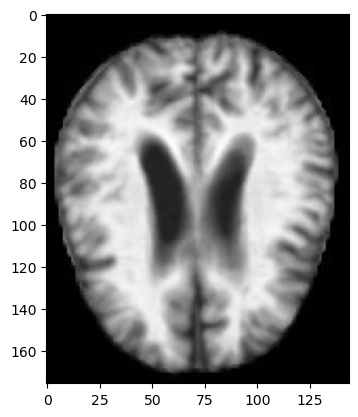

In [70]:
plt.imshow(test_images[test_labels == 1].mean(axis=0), cmap='gray')

In [71]:
test_dataset = AlzheimerDataset(test_images, test_labels)

Total Accuracy: 0.599687255668491

Precision: 
MildDemented: 0.6057692307692307
ModerateDemented: 0.5
NonDemented: 0.6168757126567845
VeryMildDemented: 0.55

Recall: 
MildDemented: 0.35195530726256985
ModerateDemented: 0.75
NonDemented: 0.8453125
VeryMildDemented: 0.34375

F1 Score:
MildDemented: 0.4452296819787986
ModerateDemented: 0.6
NonDemented: 0.7132498352010547
VeryMildDemented: 0.4230769230769231



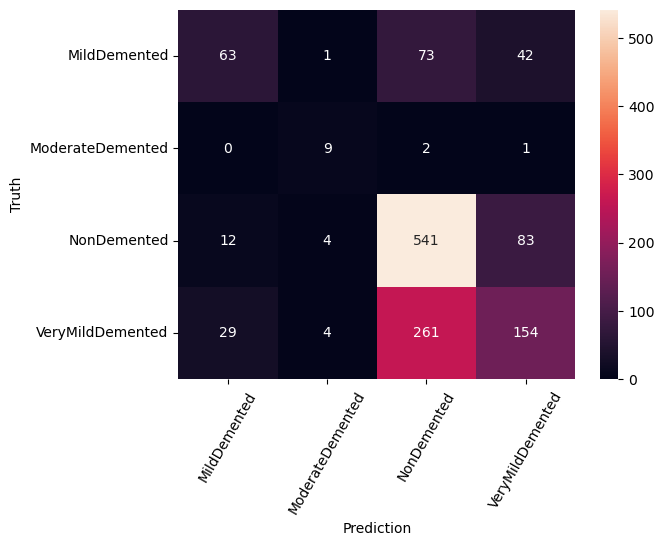

In [72]:
show_metrics(model, test_dataset)

The confusion matrix is not very assuring, and the same can be said for the `precision`, `recall` and `F1 score` for each of the classes. My guess is that the enforcement of the `KL Divergence` regularization term from the `AutoEncoder`'s training, missed a lot of important features when compressing to the latent space, in favor of making it normally distributed. So there's a tradeoff.

I'm not familiar with any methods to show it, but the easiest solution would be to train a new `AutoEncoder` without the `KL Divergence` regularization term, and obviously, without the `reparameterization trick` in the `encoder`, and compare the results.

On the other hand, the validation's metrics are off the charts. Including `accuracy` and the 3 metrics.

This is not a surprise since the hyperparameters Optuna chose for us included `fine_tune = False` which caused the entire network (mainly the `encoder`) to retrain, and specifically, with data that was used in its previous trainings, which causes an overfit.

In [74]:
import shutil
try:
    shutil.rmtree(f'./logs/classification/study-{current_study_id}')
except Exception as e:
    print(e)

#### Potential solutions

* Use a trained network that was trained on medical data such as brain images, and fine tune it to this dataset.
* Perform a more robust and comprehensive EDA and understand the domain's limitations and more advanced legitimate assumptions (maybe taking the mirror image of each brain is really wrong!).
* Try and use a ResNet model and fine tune it.

#### Results and conclusions

* The results for me are pretty disappointing. After working on such a large project for so long, with the motivation to possibly be able to help others and expecting good results, it wasn't the case. Nonetheless, this project taught me a lot on Computer Vision and problem solving. I used many techniques which I didn't learn in class, so I had to search and learn about them, which motivates self learning, which is a critical skill in this ongoing transformative field.
* I used many algorithms and techniques that I did learn in the university, and for that I saw the potential and a real-life use case for those tools.
* Regarding the results themselves, this model is not fit for production use or any use case whatsoever, but I believe that with the right approach, this direction can be very promising.

#### Compute and resources

* My compute was pretty intensive for a modern PC, using an Intel i9 13900 5GHz 24-core CPU, 32 GB of DDR5 RAM, 1TB NVME storage device and a NVIDIA RTX 4070 Super with 12 GB of VRAM, which made my life a lot easier so that I could work offline without paying for a Kaggle/Colab subscription, since the free tier GPUs performed slower, and obviously unlimited GPU time.
* For version control, I used Git and GitHub.
* For tracking my history and model's trainings and performances, I used an external PostgreSQL database using an API written in FastAPI for the reports during training, and TensorBoard for the visualizations during training.
* Most of the resources that I used in terms of ideas, explanations and code, were from Wikipedia (for a formal explanation and understanding), arXiv papers (mainly the `VAE`) and the "Deep Learning" and course by Dr. Idan Alter, "Intro to Machine Learning" course by Dr. Shay Maimon and "Image Processing" course by Dr. Azaria Cohen (for the models' training flow and EDA), both from of The Open University of Israel syllabus.

#### Personal notes

I'd like to thank Dr. Idan Alter for his help and contribution in this project. After many ping pong emails regarding ideas, implementations, directions and way of thinking, I was able to complete this project. So thank you.